In [1]:
try:
    import os
    new_directory = "workspace/"
    os.chdir(new_directory)
except:
    pass

In [2]:
# =============================
# Import
# =============================
#system    
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import yaml
import json
import importlib
import gc
import glob
import random
import copy
from collections import defaultdict
from tqdm.auto import tqdm
#the basics
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
#visualise
import shutil
from matplotlib import pyplot as plt

# ===============
# import mycode
# ===============
sys.path.append("./src")
#utils
from utils.utils import pickle_dump,pickle_load,seed_everything,AttrDict
from utils.logger import setup_logger, LOGGER
# ===============
# Read yaml     
# ===============
from argparse import ArgumentParser
try:
    parser       = ArgumentParser()
    parser.add_argument('--config', type=str)
    args         = parser.parse_args()
    config_name  = args.config
except:
    config_name = None
    
if config_name==None:
    with open('./yaml/config_HMS.yaml', 'r') as yml:
        config          = yaml.safe_load(yml)
else:
    with open('./yaml/'+config_name+'.yaml', 'r') as yml:
        config          = yaml.safe_load(yml)

# ===============
# Path_Base     
# ===============
EXP_ID                  = config['EXP_ID']
LOGGER_dir              = config['path']['LOGGER_dir']
LOGGER_PATH             = LOGGER_dir+'/log_'+EXP_ID+".txt"
input_dir               = config['path']['input_dir']
data_dir                = config['path']['data_dir']
output_dir              = config['path']['output_dir']
save_output_dir         = f'{output_dir}/{EXP_ID}'
os.makedirs(save_output_dir,exist_ok=True)

input_type              = config['dataset']['input_type']
if config['model']['model_type'] =='LOAD':
    model_type          = config['model']['model_type']
else:
    if input_type == 'SPEC':
        model_type      = 'CNN'
    elif input_type == 'EEG_WAVE':
        model_type      = 'WAVE_CNN'
    elif input_type == 'EEG_IMG':
        model_type      = 'CNN'
    elif input_type == 'ALL':
        model_type      = 'MULTI'
    config['model']['model_type']   = model_type

# ===============
# utils
# ===============
Debug                               = config['calc_mode']['Debug']
if Debug:
    config['train']['EPOCHS']          = 1
    config['train']['BATCH_SIZE_Tr']   = 2
    config['train']['BATCH_SIZE_Val']  = 2
    config['calc_mode']['Split_Mode']  = 'def'
    config['calc_mode']['NFOLDS']      = 1
    config['calc_mode']['Calc_Fold']   = [0]  
seed                    = config['train']['SEED']
seed_everything(seed)
# ===============
# LOGGER
# ===============
setup_logger(out_file=LOGGER_PATH)
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# ===============
# SAVE
# ===============
os.makedirs(f'{save_output_dir}/yaml',exist_ok=True)
with open(f'{save_output_dir}/yaml/config_HMS.yaml', 'w') as file:
    yaml.dump(config, file)
shutil.copytree('./src', f'{save_output_dir}/src', dirs_exist_ok=True)
config             = AttrDict(config)

2024-04-18 08:21:36,570 - INFO - logger set up


In [3]:
import preprocess.preprocess
importlib.reload(preprocess.preprocess)
from preprocess.preprocess import read_rawdata
#====params====#
DEVICE                          = config['train']['DEVICE']
num_Debug                       = config['calc_mode']['num_Debug']


calc_stage                          = config['calc_mode']['calc_stage']
if calc_stage == 'stage1':
    config['calc_mode']['select_train_data']   = 'All'
    config['calc_mode']['select_valid_data']   = 'All'
    config['calc_mode']['calc_valid_result']   = ['All','flg1_vote']
    config['calc_mode']['judge_valid_result']  = 'All'
    config['calc_mode']['mode_usepretrain']    = False
elif calc_stage == 'stage2':
    config['calc_mode']['select_train_data']   = 'flg1_vote' 
    config['calc_mode']['select_valid_data']   = 'All'
    config['calc_mode']['calc_valid_result']   = ['All','flg1_vote']
    config['calc_mode']['judge_valid_result']  = 'flg1_vote'
    config['calc_mode']['mode_usepretrain']    = True

#=更新=#
mode_usepretrain                = config['calc_mode']['mode_usepretrain']
if mode_usepretrain:
    config['dataset']['SPEC']['augmentation']['prob']               = config['dataset']['SPEC']['augmentation']['prob_pretrain']
    config['dataset']['SPEC']['augmentation']['stop_aug_epoch']     = config['dataset']['SPEC']['augmentation']['stop_aug_epoch_pretrain']
    config['dataset']['SPEC']['mixup']['prob']                      = config['dataset']['SPEC']['mixup']['prob_pretrain'] 
    config['dataset']['SPEC']['mixup']['alpha']                     = config['dataset']['SPEC']['mixup']['alpha_pretrain']
    config['dataset']['SPEC']['mixup']['stop_mixup_epoch']          = config['dataset']['SPEC']['mixup']['stop_mixup_epoch_pretrain']
    config['dataset']['SPEC']['time_cutmix']['prob']                = config['dataset']['SPEC']['time_cutmix']['prob_pretrain']
    config['dataset']['SPEC']['time_cutmix']['alpha']               = config['dataset']['SPEC']['time_cutmix']['alpha_pretrain']
    config['dataset']['SPEC']['time_cutmix']['stop_mixup_epoch']    = config['dataset']['SPEC']['time_cutmix']['stop_mixup_epoch_pretrain']
    config['dataset']['EEG']['augmentation']['prob']                = config['dataset']['EEG']['augmentation']['prob_pretrain']
    config['dataset']['EEG']['augmentation']['stop_aug_epoch']      = config['dataset']['EEG']['augmentation']['stop_aug_epoch_pretrain']
    config['dataset']['EEG']['mixup']['prob']                       = config['dataset']['EEG']['mixup']['prob_pretrain']
    config['dataset']['EEG']['mixup']['alpha']                      = config['dataset']['EEG']['mixup']['alpha_pretrain']
    config['dataset']['EEG']['mixup']['stop_mixup_epoch']           = config['dataset']['EEG']['mixup']['stop_mixup_epoch_pretrain']
    config['dataset']['EEG']['time_cutmix']['prob']                 = config['dataset']['EEG']['time_cutmix']['prob_pretrain']
    config['dataset']['EEG']['time_cutmix']['alpha']                = config['dataset']['EEG']['time_cutmix']['alpha_pretrain']
    config['dataset']['EEG']['time_cutmix']['stop_mixup_epoch']     = config['dataset']['EEG']['time_cutmix']['stop_mixup_epoch_pretrain']
    config['dataset']['EEG_IMG']['augmentation']['prob']            = config['dataset']['EEG_IMG']['augmentation']['prob_pretrain']
    config['dataset']['EEG_IMG']['augmentation']['stop_aug_epoch']  = config['dataset']['EEG_IMG']['augmentation']['stop_aug_epoch_pretrain']
    config['dataset']['EEG_IMG']['mixup']['prob']                   = config['dataset']['EEG_IMG']['mixup']['prob_pretrain']
    config['dataset']['EEG_IMG']['mixup']['alpha']                  = config['dataset']['EEG_IMG']['mixup']['alpha_pretrain']
    config['dataset']['EEG_IMG']['mixup']['stop_mixup_epoch']       = config['dataset']['EEG_IMG']['mixup']['stop_mixup_epoch_pretrain']
    config['dataset']['EEG_IMG']['time_cutmix']['prob']             = config['dataset']['EEG_IMG']['time_cutmix']['prob_pretrain']
    config['dataset']['EEG_IMG']['time_cutmix']['alpha']            = config['dataset']['EEG_IMG']['time_cutmix']['alpha_pretrain']
    config['dataset']['EEG_IMG']['time_cutmix']['stop_mixup_epoch'] = config['dataset']['EEG_IMG']['time_cutmix']['stop_mixup_epoch_pretrain']
    config['train']['EPOCHS_SETTING']['SPEC']                       = config['train']['EPOCHS_SETTING']['SPEC_pretrain']
    config['train']['EPOCHS_SETTING']['EEG_WAVE']                   = config['train']['EPOCHS_SETTING']['EEG_WAVE_pretrain']
    config['train']['EPOCHS_SETTING']['EEG_IMG']                    = config['train']['EPOCHS_SETTING']['EEG_IMG_pretrain']
    config['train']['OPTIMIZER']['LEARNING_RATE_SPEC']              = config['train']['OPTIMIZER']['LEARNING_RATE_SPEC_pretrain']
    config['train']['OPTIMIZER']['LEARNING_RATE_EEG_WAVE']          = config['train']['OPTIMIZER']['LEARNING_RATE_EEG_WAVE_pretrain']
    config['train']['OPTIMIZER']['LEARNING_RATE_EEG_IMG']           = config['train']['OPTIMIZER']['LEARNING_RATE_EEG_IMG_pretrain']
    #ALL
    config['dataset']['ALL']['augmentation']['prob']               = config['dataset']['ALL']['augmentation']['prob_pretrain']
    config['dataset']['ALL']['augmentation']['stop_aug_epoch']     = config['dataset']['ALL']['augmentation']['stop_aug_epoch_pretrain']
    config['dataset']['ALL']['mixup']['prob']                      = config['dataset']['ALL']['mixup']['prob_pretrain'] 
    config['dataset']['ALL']['mixup']['alpha']                     = config['dataset']['ALL']['mixup']['alpha_pretrain']
    config['dataset']['ALL']['mixup']['stop_mixup_epoch']          = config['dataset']['ALL']['mixup']['stop_mixup_epoch_pretrain']
    config['dataset']['ALL']['time_cutmix']['prob']                = config['dataset']['ALL']['time_cutmix']['prob_pretrain']
    config['dataset']['ALL']['time_cutmix']['alpha']               = config['dataset']['ALL']['time_cutmix']['alpha_pretrain']
    config['dataset']['ALL']['time_cutmix']['stop_mixup_epoch']    = config['dataset']['ALL']['time_cutmix']['stop_mixup_epoch_pretrain']
    config['train']['EPOCHS_SETTING']['ALL']                       = config['train']['EPOCHS_SETTING']['ALL_pretrain']
    config['train']['OPTIMIZER']['LEARNING_RATE_ALL']              = config['train']['OPTIMIZER']['LEARNING_RATE_ALL_pretrain']


#====Read Data====#
train_meta                      = pd.read_csv(data_dir + "/train.csv")
files_train_eegs                = glob.glob(f'{data_dir}/train_eegs/*')
files_train_eegs_names          = [int(os.path.basename(file).split('.')[0]) for file in files_train_eegs]
files_train_spectrograms        = glob.glob(f'{data_dir}/train_spectrograms/*')
files_train_spectrograms_names  = [int(os.path.basename(file).split('.')[0]) for file in files_train_spectrograms]

#=====split_data=====#
if (config['calc_mode']['Split_Mode'] == 'TH_folds1'):
    train_meta_TH               = pd.read_csv(data_dir + "/folds1.csv")
elif (config['calc_mode']['Split_Mode'] == 'TH_folds2'):
    train_meta_TH               = pd.read_csv(data_dir + "/folds2.csv")
train_meta_TH                   = train_meta_TH.rename(columns={'fold':'fold_TH'})
train_meta                      = pd.merge(train_meta,train_meta_TH[['label_id','fold_TH','eeg_nan_ratio','spec_nan_ratio','eeg_std_0']],on='label_id',how='left')
train_meta['fold']              = train_meta['fold_TH'].values


#====Read RawData====#
train_eegs_data_dict,len_train_eegs_data_dict,col_eegs,\
dict_col_index,list_max_eeg,list_min_eeg,list_nan_eeg_id,\
train_spectrograms_data_dict,len_train_spectrograms_data_dict,\
col_spectrograms,dict_col_index,list_nan_spec_id               = read_rawdata(config,data_dir,output_dir,input_type,\
                                                                              files_train_eegs_names,files_train_spectrograms_names)

#=====Add Select Flg=====#
th_vote                             = config['calc_mode']['thresh_total_vote']
col_labels                          = config['dataset']['col_labels']
col_labels_ratio                    = [f'{col}_ratio' for col in col_labels]
train_meta['sum_vote']              = train_meta[col_labels].sum(axis=1)
for col in col_labels:
    train_meta[f'{col}_ratio']      = train_meta[col]/train_meta['sum_vote']
    
#==Flg1:sum_vote&maxratio dict_labelid2sumvote,dict_labelid2maxratio==#
select_rule1                        = (train_meta['sum_vote']>=th_vote)
train_meta['flg1_vote']             = select_rule1
dict_labelid2flg1vote               = train_meta.set_index('label_id')['flg1_vote'].to_dict()

In [4]:
import trainer.datasets
importlib.reload(trainer.datasets)
from trainer.datasets import HMS_Dataset
#====dataset_save_mode EEG_IMG====#
dataset_mode_EEG_IMG                    = config['dataset']['EEG_IMG']['dataset_mode'] #'load','pass'
save_eeg_img                            = (input_type=='EEG_IMG' and (dataset_mode_EEG_IMG=='save')) or\
                                          (input_type=='ALL'     and (dataset_mode_EEG_IMG=='save'))
if save_eeg_img:
    LOGGER.info(f'============Save EEG_IMG============')
    tmp_select_data                     = config['dataset']['select_data']
    config['dataset']['select_data']    = 'use_alldata'
    save_dataset_dir                    = f'{output_dir}/{EXP_ID}/dataset'
    os.makedirs(save_dataset_dir,exist_ok=True) 
    save_dataset                        = HMS_Dataset(train_meta,train_eegs_data_dict,train_spectrograms_data_dict,dict_col_index,
                                          config,phase='valid')
    save_dataset.update_for_epoch(0)
    dict_EEG_IMG                        = dict()
    for idx in range(len(save_dataset)):
        if idx%1000==0:
            LOGGER.info(f'idx:{idx}')
        eeg_id                          = save_dataset[idx]['eeg_id']
        dict_EEG_IMG[eeg_id]            = save_dataset[idx]['sub_eeg_data_img']
    pickle_dump(dict_EEG_IMG,f'{save_dataset_dir}/dict_EEG_IMG.pkl')
    #更新
    config['dataset']['EEG_IMG']['dataset_mode']   = 'load'
    config['dataset']['select_data']               = tmp_select_data
else:
    pass

2024-04-18 08:21:51,354 - INFO - ============Fold:0 Start============


calc_spec:False,calc_eeg_wave:True,load_eeg_wave:False,calc_eeg_img:False,load_eeg_img:False
calc_spec:False,calc_eeg_wave:True,load_eeg_wave:False,calc_eeg_img:False,load_eeg_img:False


2024-04-18 08:21:52,917 - INFO - Loading pretrained weights from Hugging Face hub (timm/maxxvitv2_nano_rw_256.sw_in1k)
2024-04-18 08:21:53,619 - INFO - [timm/maxxvitv2_nano_rw_256.sw_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-04-18 08:21:53,631 - INFO - Converted input conv stem.conv1 pretrained weights from 3 to 1 channel(s)
2024-04-18 08:21:53,758 - INFO - ======Start_Train======
2024-04-18 08:21:53,765 - INFO - ===input_type=EEG_WAVE===
2024-04-18 08:21:53,766 - INFO - ===model_type=WAVE_CNN===
2024-04-18 08:21:53,766 - INFO - ===mode_usepretrain=False===
2024-04-18 08:21:53,767 - INFO - ===select_train_data=All===
2024-04-18 08:21:53,768 - INFO - ===select_valid_data=All===
2024-04-18 08:21:53,768 - INFO - ===calc_valid_result=['All', 'flg1_vote']===
2024-04-18 08:21:53,769 - INFO - ===judge_valid_result=All===
2024-04-18 08:21:53,770 - INFO - ===Starting training loop===
2024-04-18 08:21:53,771 - INFO 

calc_spec:False,calc_eeg_wave:True,load_eeg_wave:False,calc_eeg_img:False,load_eeg_img:False
calc_spec:False,calc_eeg_wave:True,load_eeg_wave:False,calc_eeg_img:False,load_eeg_img:False


2024-04-18 08:38:39,282 - INFO - Loading pretrained weights from Hugging Face hub (timm/maxxvitv2_nano_rw_256.sw_in1k)
2024-04-18 08:38:39,602 - INFO - [timm/maxxvitv2_nano_rw_256.sw_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2024-04-18 08:38:39,622 - INFO - Converted input conv stem.conv1 pretrained weights from 3 to 1 channel(s)
2024-04-18 08:38:39,689 - INFO - ======Start_Train======
2024-04-18 08:38:39,697 - INFO - ===input_type=EEG_WAVE===
2024-04-18 08:38:39,698 - INFO - ===model_type=WAVE_CNN===
2024-04-18 08:38:39,699 - INFO - ===mode_usepretrain=False===
2024-04-18 08:38:39,700 - INFO - ===select_train_data=All===
2024-04-18 08:38:39,700 - INFO - ===select_valid_data=All===
2024-04-18 08:38:39,701 - INFO - ===calc_valid_result=['All', 'flg1_vote']===
2024-04-18 08:38:39,702 - INFO - ===judge_valid_result=All===
2024-04-18 08:38:39,702 - INFO - ===Starting training loop===
2024-04-18 08:38:39,703 - INFO 

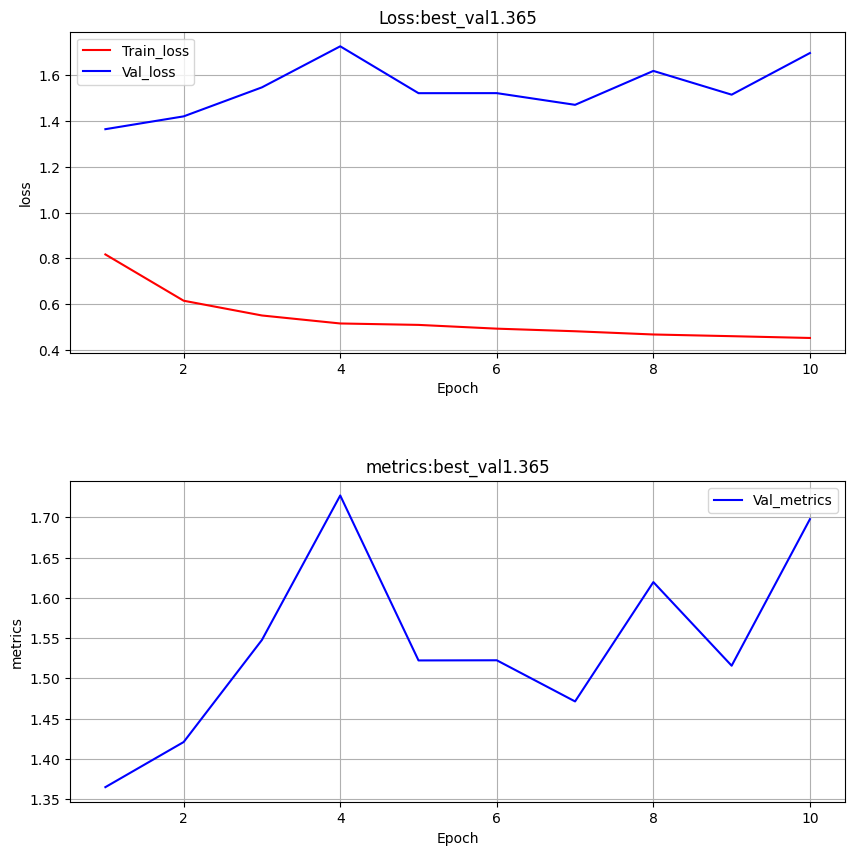

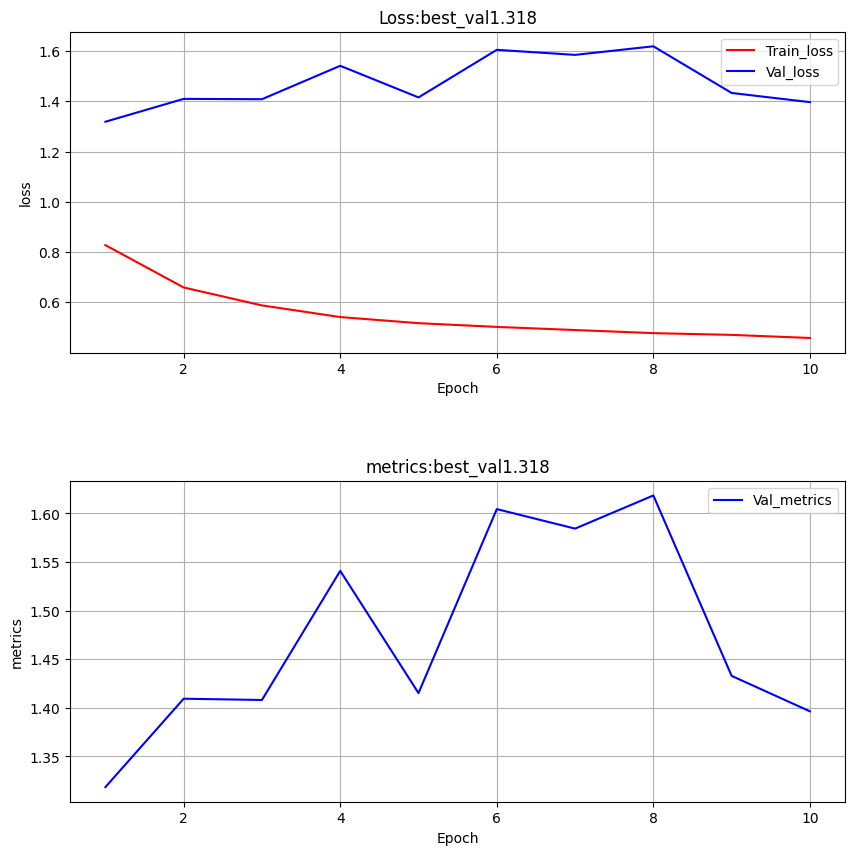

In [5]:
import preprocess.preprocess
import trainer.datasets
import trainer.train
import models.model_HMS_CNN
import models.model_HMS_WAVE_CNN
import models.model_HMS_MULTI
importlib.reload(preprocess.preprocess)
importlib.reload(trainer.datasets)
importlib.reload(trainer.train)
importlib.reload(models.model_HMS_CNN)
importlib.reload(models.model_HMS_WAVE_CNN)
importlib.reload(models.model_HMS_MULTI)
from trainer.datasets import HMS_Dataset
from trainer.train import calc_train,get_fig
from models.model_HMS_CNN import HMSModel_CNN
from models.model_HMS_WAVE_CNN import HMSModel_WAVE_CNN
from models.model_HMS_MULTI import HMSModel_MULTI
from trainer.metrics  import score
from transformers import get_cosine_schedule_with_warmup

def select_df(df_fold,select_setting):
    if select_setting == 'All':
        df_fold                 = df_fold.copy()
    elif select_setting=='flg1_vote':
        df_fold                 = df_fold[df_fold['flg1_vote']==True].reset_index(drop=True)
    #flg1_voteがTrueのものがあるeeg_idはTrueだけ残す
    df_fold['has_true']         = df_fold.groupby('eeg_id')['flg1_vote'].transform('max')
    df_fold                     = df_fold[(df_fold['flg1_vote'] == True) | (df_fold['has_true'] == False)]
    df_fold                     = df_fold.drop(columns=['has_true'])
    df_fold                     = df_fold.reset_index(drop=True)
    return df_fold

#=setting=#
if input_type == 'SPEC':
    config.train.EPOCHS                  = config.train.EPOCHS_SETTING.SPEC
    config.train.BATCH_SIZE_Tr           = config.train.BATCH_SIZE_SETTING.SPEC
    config.train.BATCH_SIZE_Val          = config.train.BATCH_SIZE_SETTING.SPEC
    config.train.OPTIMIZER.LEARNING_RATE = config.train.OPTIMIZER.LEARNING_RATE_SPEC
    config.train.OPTIMIZER.WEIGHT_DECAY  = config.train.OPTIMIZER.WEIGHT_DECAY_SPEC
elif input_type == 'EEG_IMG':
    config.train.EPOCHS                  = config.train.EPOCHS_SETTING.EEG_IMG
    config.train.BATCH_SIZE_Tr           = config.train.BATCH_SIZE_SETTING.EEG_IMG
    config.train.BATCH_SIZE_Val          = config.train.BATCH_SIZE_SETTING.EEG_IMG
    config.train.OPTIMIZER.LEARNING_RATE = config.train.OPTIMIZER.LEARNING_RATE_EEG_IMG
    config.train.OPTIMIZER.WEIGHT_DECAY  = config.train.OPTIMIZER.WEIGHT_DECAY_EEG_IMG
elif input_type == 'EEG_WAVE':
    config.train.EPOCHS                  = config.train.EPOCHS_SETTING.EEG_WAVE
    config.train.BATCH_SIZE_Tr           = config.train.BATCH_SIZE_SETTING.EEG_WAVE
    config.train.BATCH_SIZE_Val          = config.train.BATCH_SIZE_SETTING.EEG_WAVE
    config.train.OPTIMIZER.LEARNING_RATE = config.train.OPTIMIZER.LEARNING_RATE_EEG_WAVE
    config.train.OPTIMIZER.WEIGHT_DECAY  = config.train.OPTIMIZER.WEIGHT_DECAY_EEG_WAVE
elif input_type == 'ALL':
    config.train.EPOCHS                  = config.train.EPOCHS_SETTING.ALL
    config.train.BATCH_SIZE_Tr           = config.train.BATCH_SIZE_SETTING.ALL
    config.train.BATCH_SIZE_Val          = config.train.BATCH_SIZE_SETTING.ALL
    config.train.OPTIMIZER.LEARNING_RATE = config.train.OPTIMIZER.LEARNING_RATE_ALL
    config.train.OPTIMIZER.WEIGHT_DECAY  = config.train.OPTIMIZER.WEIGHT_DECAY_ALL

#====train====#
eeg_nan_ratio_thresh_train  = config['calc_mode']['eeg_nan_ratio_thresh_train']

#=Main=#
history                     = defaultdict(list) 
idx_train_folds             = []
idx_valid_folds             = []
select_train_data           = config['calc_mode']['select_train_data']
select_valid_data           = config['calc_mode']['select_valid_data']
judge_valid_result          = config['calc_mode']['judge_valid_result']
for id_fold in config.calc_mode.Calc_Fold:
    LOGGER.info(f'============Fold:{id_fold} Start============')
    save_output_dir_fold    = f'{save_output_dir}/fold_{id_fold}'
    os.makedirs(save_output_dir_fold,exist_ok=True)
    #===split_data===#
    idx_train               = train_meta[train_meta['fold']!=id_fold].index.values
    idx_valid               = train_meta[train_meta['fold']==id_fold].index.values
    df_fold_train           = train_meta.iloc[idx_train].reset_index(drop=True)
    df_fold_valid           = train_meta.iloc[idx_valid].reset_index(drop=True)

    #===select_data_train===#
    df_fold_train           = df_fold_train[df_fold_train["eeg_nan_ratio"] <= eeg_nan_ratio_thresh_train]
    df_fold_train           = df_fold_train[df_fold_train["eeg_std_0"] == False].reset_index(drop=True)
    df_fold_valid           = df_fold_valid[df_fold_valid["eeg_std_0"] == False].reset_index(drop=True)

    #===select_data===#

    df_fold_train           = select_df(df_fold_train,select_train_data)
    df_fold_valid           = select_df(df_fold_valid,select_valid_data)
    df_fold_valid_judge     = select_df(df_fold_valid,judge_valid_result)
    
    #===dataset===#
    train_dataset           = HMS_Dataset(df_fold_train,train_eegs_data_dict,train_spectrograms_data_dict,dict_col_index,
                                          config,phase='train')
    valid_dataset           = HMS_Dataset(df_fold_valid,train_eegs_data_dict,train_spectrograms_data_dict,dict_col_index,
                                          config,phase='valid')
    train_dataset.update_for_epoch(0)
    valid_dataset.update_for_epoch(0)
    train_loader            = DataLoader(train_dataset, batch_size=config.train.BATCH_SIZE_Tr, shuffle=True,
                                         num_workers=config.train.NUM_WORKERS,pin_memory=True)
    valid_loader            = DataLoader(valid_dataset, batch_size=config.train.BATCH_SIZE_Val, shuffle=False,
                                         num_workers=config.train.NUM_WORKERS,pin_memory=True)
    
    #===model===#
    if model_type == 'CNN':
        model               = HMSModel_CNN(config,input_type=input_type)
    elif model_type == 'WAVE_CNN':
        model               = HMSModel_WAVE_CNN(config)
    elif model_type == 'MULTI':
        model               = HMSModel_MULTI(config,id_fold=id_fold)
    elif model_type == 'LOAD':
        exp_id_load         = config['model']['LOAD']['exp_id_load']
        path_model_load     = f'{output_dir}/{exp_id_load}/fold_{id_fold}/best.pt'
        model               = torch.load(path_model_load)
        load_model_type     = model.config.model.model_type
        config['model']['model_type'] = load_model_type
        LOGGER.info(f"======Model Load======")
        LOGGER.info(f"===exp_id_load={exp_id_load}===")
    model                   = model.to(DEVICE)
    
    #===loss===#
    loss_function           = torch.nn.KLDivLoss(reduction="batchmean")
    loss_function           = loss_function.to(DEVICE)
    
    #===optimizerl===#
    if (input_type == 'SPEC')&(config['model']['CNN_SPEC']['ch_head']=='cnn2d'):
        special_params      = list(model.backbone_ch_head.parameters())
        special_params_ids  = {id(p) for p in special_params}
        base_params         = [p for p in model.parameters() if id(p) not in special_params_ids]
        optimizer           = torch.optim.Adam(
                                [
                                    {"params": base_params, "lr": config.train.OPTIMIZER.LEARNING_RATE},
                                    {"params": special_params, "lr": 0.03*config.train.OPTIMIZER.LEARNING_RATE},#0.03
                                ],
                                weight_decay=config.train.OPTIMIZER.WEIGHT_DECAY,)
    elif (input_type == 'EEG_IMG')&(config['model']['CNN_EEG']['ch_head']=='cnn2d'):
        special_params      = list(model.backbone_ch_head.parameters())
        special_params_ids  = {id(p) for p in special_params}
        base_params         = [p for p in model.parameters() if id(p) not in special_params_ids]
        optimizer           = torch.optim.Adam(
                                [
                                    {"params": base_params, "lr": config.train.OPTIMIZER.LEARNING_RATE},
                                    {"params": special_params, "lr": 0.03*config.train.OPTIMIZER.LEARNING_RATE},#0.03
                                ],
                                weight_decay=config.train.OPTIMIZER.WEIGHT_DECAY,)
    elif (input_type == 'EEG_WAVE')&(config['model']['WAVE_EEG_CNN']['ch_head']=='cnn2d'):
        special_params      = list(model.backbone_ch_head.parameters())
        special_params_ids  = {id(p) for p in special_params}
        base_params         = [p for p in model.parameters() if id(p) not in special_params_ids]
        optimizer           = torch.optim.Adam(
                                [
                                    {"params": base_params, "lr": config.train.OPTIMIZER.LEARNING_RATE,"weight_decay":1.e-7},
                                    {"params": special_params, "lr": 0.06*config.train.OPTIMIZER.LEARNING_RATE,"weight_decay":1.e-7},#0.03
                                ],
                                weight_decay=config.train.OPTIMIZER.WEIGHT_DECAY,)
        
    elif (input_type == 'ALL'):
        special_params1 = list(model.model_spec.backbone_ch_head.parameters())
        special_params2 = list(model.model_eeg_wave.backbone_ch_head.parameters())
        special_params3 = list(model.model_eeg_img.backbone_ch_head.parameters())

        special_params_ids1 = {id(p) for p in special_params1}
        special_params_ids2 = {id(p) for p in special_params2}
        special_params_ids3 = {id(p) for p in special_params3}

        base_params = [p for p in model.parameters() if id(p) not in special_params_ids1 and id(p) not in special_params_ids2 and id(p) not in special_params_ids3]

        optimizer = torch.optim.Adam(
            [
                {"params": base_params,     "lr": config.train.OPTIMIZER.LEARNING_RATE, "weight_decay": 1.e-7},
                {"params": special_params1, "lr": 0.03 * config.train.OPTIMIZER.LEARNING_RATE, "weight_decay": 1.e-7},
                {"params": special_params2, "lr": 0.06 * config.train.OPTIMIZER.LEARNING_RATE, "weight_decay": 1.e-7},
                {"params": special_params3, "lr": 0.03 * config.train.OPTIMIZER.LEARNING_RATE, "weight_decay": 1.e-7},
            ],
            weight_decay=config.train.OPTIMIZER.WEIGHT_DECAY,
        )
    else:
        optimizer               = torch.optim.Adam(model.parameters(),
                                                lr=config.train.OPTIMIZER.LEARNING_RATE,
                                                weight_decay=config.train.OPTIMIZER.WEIGHT_DECAY)
    
    #===schedulerl===#
    max_steps               = config.train.EPOCHS * len(train_loader)
    warmup_steps            = 0
    scheduler               = get_cosine_schedule_with_warmup(optimizer, num_training_steps=max_steps,
                                                                num_warmup_steps=warmup_steps)

    LOGGER.info('======Start_Train======')
    history_fold            = dict()
    history_fold            = calc_train(model, config, train_dataset, valid_dataset,train_loader, valid_loader,
                                         optimizer,scheduler,loss_function,save_output_dir_fold,LOGGER,history_fold,
                                         df_fold_valid)
    # ===============
    # save_fig
    # =============== 
    get_fig(history_fold,save_output_dir_fold,config)
    # ===============
    # result_fold
    # =============== 
    LOGGER.info(f'============Fold:{id_fold} END============')
    history[id_fold]        = history_fold
    history_fold['best_df_valid_output'].to_csv(f'{save_output_dir_fold}/df_valid_output.csv')
    history_fold['best_df_valid_labels'].to_csv(f'{save_output_dir_fold}/df_valid_labels.csv')
    LOGGER.info('Best_Ep ' + str(history_fold['best_epoch']) +  ',Best_val_loss: ' + str(np.round(history_fold['best_valid_losses'],4))+
                ',Best_val_metrics: ' + str(np.round(history_fold['best_valid_metrics'],4)))
    formatted_mae = [f'{val:.2f}' for val in history_fold['best_valid_MAE']]
    formatted_acc = [f'{val:.1f}' for val in history_fold['best_valid_ACC']]
    LOGGER.info(f'======Best_MAE : {formatted_mae}======')
    LOGGER.info(f'======Best_ACC : {formatted_acc}======')
    #folds
    history_fold['idx_train'] = idx_train
    history_fold['idx_valid'] = idx_valid
    idx_train_folds.append(idx_train)
    idx_valid_folds.append(idx_valid)

    # ===============
    # OOF_fold
    # =============== 
    LOGGER.info(f'============Fold:{id_fold} END============')
    del train_dataset,valid_dataset,train_loader,valid_loader
    gc.collect()
    torch.cuda.empty_cache()  

# ===============
# result_all
# =============== 
#===result_all===#
best_epochs             = []
folds                   = []
best_train_losses       = []
best_valid_losses       = []
best_valid_metrics      = []
best_valid_maes         = []
best_valid_accs         = []
for idx,id_fold in enumerate(config.calc_mode.Calc_Fold):
    folds.append(int(id_fold))
    best_epochs.append(int(history[id_fold]['best_epoch']))
    best_train_losses.append(history[id_fold]['best_train_losses'])
    best_valid_losses.append(history[id_fold]['best_valid_losses'])
    best_valid_metrics.append(history[id_fold]['best_valid_metrics'])
    best_valid_maes.append(history[id_fold]['best_valid_MAE'])
    best_valid_accs.append(history[id_fold]['best_valid_ACC'])
df_result                               = pd.DataFrame()
df_result['folds']                      = folds
df_result['best_epochs']                = best_epochs
df_result['best_train_losse']           = best_train_losses
df_result['best_valid_losse']           = best_valid_losses
df_result['best_valid_metrics']         = best_valid_metrics
df_result                               = df_result.T
df_result.to_csv(f'{save_output_dir}/df_result.csv')

#=df_oof=#
for idx,id_fold in enumerate(config.calc_mode.Calc_Fold):
    if idx==0:
        df_oof_output       = history[id_fold]['best_df_valid_output']
        df_oof_labels       = history[id_fold]['best_df_valid_labels']
    else:
        df_oof_output       = pd.concat([df_oof_output,history[id_fold]['best_df_valid_output']],axis=0).reset_index(drop=True)
        df_oof_labels       = pd.concat([df_oof_labels,history[id_fold]['best_df_valid_labels']],axis=0).reset_index(drop=True)

df_oof_output_score         = df_oof_output[config['dataset']['col_labels']]
df_oof_labels_score         = df_oof_labels[config['dataset']['col_labels']]
df_oof_output_score['id']   = np.arange(len(df_oof_output_score))
df_oof_labels_score['id']   = np.arange(len(df_oof_labels_score))
oof_metrics                 = score(solution=df_oof_labels_score.copy(), submission=df_oof_output_score.copy(), 
                                                row_id_column_name='id')

df_oof_output.to_csv(f'{save_output_dir}/df_oof_output.csv')
df_oof_labels.to_csv(f'{save_output_dir}/df_oof_labels.csv')
LOGGER.info('Best_Valid_Metrics_OOF    : '+str(np.round(oof_metrics,4)))
LOGGER.info('Best_Valid_Metrics_FoldAve: '+str(np.round(np.mean(best_valid_metrics),4)))

#===other===#
proba_pred                              = torch.tensor(df_oof_output[config['dataset']['col_labels']].values)
label                                   = torch.tensor(df_oof_labels[config['dataset']['col_labels']].values)
mae                                     = abs(proba_pred-label).mean(axis=0).tolist()
acc                                     = []
predicted_classes                       = torch.argmax(proba_pred, dim=1)
label_classes                           = torch.argmax(label, dim=1)
for c in range(proba_pred.shape[1]):
    class_mask                          = label_classes == c
    class_predictions                   = predicted_classes[class_mask]
    class_labels                        = label_classes[class_mask]
    correct_predictions                 = torch.eq(class_predictions, class_labels)
    accuracy                            = torch.mean(correct_predictions.float())
    acc.append(accuracy.item() * 100)
history['oof_MAE']          = mae
history['oof_ACC']          = acc
formatted_mae = [f'{val:.2f}' for val in mae]
formatted_acc = [f'{val:.1f}' for val in acc]
LOGGER.info(f'======oof_MAE : {formatted_mae}======')
LOGGER.info(f'======oof_ACC : {formatted_acc}======')

#=file_splits=#
train_meta.to_csv(f'{save_output_dir}/train_meta.csv')
file_splits                 = dict()
file_splits['train']        = idx_train_folds
file_splits['valid']        = idx_valid_folds
pickle_dump(file_splits,f'{save_output_dir}/file_splits.pkl')

#=全部=#
pickle_dump(history,f'{save_output_dir}/history.pkl')